In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
movie = pd.read_csv('movies.csv', index_col='movieId')
rating = pd.read_csv('ratings.csv')

In [3]:
movie.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


C:\Users\82109\anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

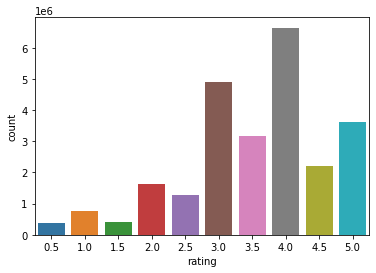

In [5]:
# 평점 분포 : 4점이 가장 많다.
sns.countplot(rating['rating'])

In [7]:
print("영화 수 :", movie.index.nunique())
print("유저 수 :", rating['userId'].nunique())

영화 수 : 62423
유저 수 : 162541


In [8]:
# 평점을 일정 수준 이하로 받은 영화는 필터링
min_movie_ratings = 300
filter_movies = (rating['movieId'].value_counts() > min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# 평점을 일정 수준 이하로 준 유저는 필터링
min_user_ratings = 150
filter_users = (rating['userId'].value_counts() > min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

rating_filterd = rating[(rating['movieId'].isin(filter_movies)) & (rating['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('필터링 전 유저 평점 총 수:\t{}'.format(len(rating)))
print('필터링 후 유저 평점 총 수:\t{}'.format(len(rating_filterd)))

필터링 전 유저 평점 총 수:	25000095
필터링 후 유저 평점 총 수:	16857144


In [9]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(rating_filterd)
del rating_filterd

In [10]:
df_p = pd.pivot_table(df_train, index='userId', columns='movieId', values='rating')

print(df_p.shape)

(43645, 6789)


In [11]:
df_p.sample(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,200540,200818,200838,201588,201646,201773,202103,202429,202439,204698
userId,,,,,,,,,,,,,,,,,,,,,
17259,4.0,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2054,NaN,3.0,NaN,NaN,3.0,3.0,3.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81666,5.0,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104395,4.5,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70446,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33452,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76629,3.5,2.5,2.0,NaN,1.0,4.0,1.5,NaN,1.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103213,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 인기 기반 추천

가장 간단하게 생각할 수 있는 추천 방법은 모든 유저에게 평점 평균이 높은, 즉 인기가 많은 작품을 추천하는 것이다.

In [12]:
import numpy as np

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
# 가장 평점이 높은 n개의 영화 추출
n = 10

In [15]:
# 모든 영화의 평균 평점을 계산
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('mean rating').to_frame()
ratings_mean.head()

,mean rating
movieId,
171011,4.487441
159817,4.462002
170705,4.388889
318,4.377500
179135,4.341317


In [16]:
# 모든 영화의 평점 개수
ratings_count = df_p.count(axis=0).rename('num of ratings').to_frame()
ratings_count.head()

,num of ratings
movieId,
1,21107
2,11574
3,3987
4,1150
5,3796


In [17]:
# 평균 평점, 평점 개수, 영화 제목을 하나의 데이터프레임으로 합친다
ratings_with_title = ratings_mean.join(ratings_count).join(movie.drop('genres', axis=1))
ratings_with_title.head()

,mean rating,num of ratings,title
movieId,,,
171011,4.487441,637,Planet Earth II (2016)
159817,4.462002,1079,Planet Earth (2006)
170705,4.388889,855,Band of Brothers (2001)
318,4.377500,23653,"Shawshank Redemption, The (1994)"
179135,4.341317,334,Blue Planet II (2017)


In [19]:
# 테스트 데이터에 대해 예측값을 구한다
df_prediction = df_test.set_index('movieId').join(ratings_mean)[['rating', 'mean rating']]
df_prediction.head()

,rating,mean rating
movieId,,
1,3.0,3.857062
1,5.0,3.857062
1,3.0,3.857062
1,3.5,3.857062
1,3.5,3.857062


In [21]:
# RMSE 계산
y_true = df_prediction['rating']
y_pred = df_prediction['mean rating']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("RMSE of recommendation by popularity :", rmse)

RMSE of recommendation by popularity : 0.9415425331764044


In [22]:
# 가장 평균 평점이 높은 n개 영화를 뽑아 본다.
# 단, 평점 개수가 적을 수록 평점 평균이 왜곡되기 쉽다
ratings_with_title.head(n)

,mean rating,num of ratings,title
movieId,,,
171011,4.487441,637,Planet Earth II (2016)
159817,4.462002,1079,Planet Earth (2006)
170705,4.388889,855,Band of Brothers (2001)
318,4.377500,23653,"Shawshank Redemption, The (1994)"
179135,4.341317,334,Blue Planet II (2017)
858,4.313553,19228,"Godfather, The (1972)"
142115,4.263780,381,The Blue Planet (2001)
50,4.259902,19567,"Usual Suspects, The (1995)"
2019,4.242171,6770,Seven Samurai (Shichinin no samurai) (1954)


# 상품 중심 협업 필터링

평점 데이터를 기반으로 주어진 상품과 비슷한 상품을 찾고, 그 상품들의 평점을 이용해 주어진 상품의 평점을 예측

In [23]:
# 유저-영화 행렬에서 비어 있는 값을 유저의 평균 평점으로 채운다
df_p_imputed = df_p.T.fillna(df_p.mean(axis='columns')).T
df_p_imputed.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,200540,200818,200838,201588,201646,201773,202103,202429,202439,204698
userId,,,,,,,,,,,,,,,,,,,,,
2,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,...,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029,3.708029
3,4.000000,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,...,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347,3.693347
4,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471,...,3.376471,3.376471,3.000000,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471,3.376471
8,4.000000,3.609091,4.000000,3.609091,3.609091,3.000000,1.000000,3.609091,3.609091,3.609091,...,3.609091,3.609091,3.609091,3.609091,3.609091,3.609091,3.609091,3.609091,3.609091,3.609091
9,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,5.000000,...,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962,3.854962


In [24]:
# 두 영화의 평점 분포가 비슷한지 계산은 코사인 유사도로 한다
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
df_p_imputed_T = df_p_imputed.T

In [68]:
# 비슷한 n개의 영화를 통해 예측
n_similar_movies = 20

In [32]:
df_p_imputed_T

userId,2,3,4,8,9,12,13,18,19,23,...,162515,162516,162519,162521,162524,162529,162533,162534,162538,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,3.708029,4.000000,3.376471,4.000000,3.854962,3.323091,3.550505,3.000000,3.380515,4.104089,...,2.500000,4.500000,5.000000,3.813869,4.500000,2.000000,3.632075,4.000000,3.540179,3.402174
2,3.708029,3.693347,3.376471,3.609091,3.854962,2.000000,3.550505,3.463504,3.380515,4.104089,...,3.506993,3.183024,2.000000,3.813869,3.647929,3.939716,4.000000,3.320359,3.540179,3.402174
3,3.708029,3.693347,3.376471,4.000000,3.854962,2.000000,3.550505,1.500000,3.380515,5.000000,...,3.506993,0.500000,3.343358,3.813869,3.647929,1.000000,3.632075,3.320359,3.540179,3.402174
4,3.708029,3.693347,3.376471,3.609091,3.854962,3.323091,3.550505,3.463504,3.380515,4.104089,...,3.506993,2.000000,3.343358,3.813869,3.647929,3.939716,3.632075,3.320359,3.540179,3.402174
5,3.708029,3.693347,3.376471,3.609091,3.854962,3.323091,3.550505,4.000000,3.380515,4.104089,...,3.506993,3.183024,3.343358,3.813869,3.647929,3.939716,3.632075,3.320359,3.540179,3.402174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201773,3.708029,3.693347,3.376471,3.609091,3.854962,3.323091,3.550505,3.463504,3.380515,4.104089,...,3.506993,3.183024,3.343358,3.813869,3.647929,3.939716,3.632075,3.320359,3.540179,3.402174
202103,3.708029,3.693347,3.376471,3.609091,3.854962,3.323091,3.550505,3.463504,3.380515,4.104089,...,3.506993,3.183024,3.343358,3.813869,3.647929,3.939716,3.632075,3.320359,3.540179,3.402174
202429,3.708029,3.693347,3.376471,3.609091,3.854962,3.323091,3.550505,3.463504,3.380515,4.104089,...,3.506993,3.183024,3.343358,3.813869,3.647929,3.939716,3.632075,3.320359,3.540179,3.402174


In [69]:
movie_scores_dfs = []
for movieId in tqdm(df_test['movieId'].unique()):
    similarities = cosine_similarity(df_p_imputed_T.loc[df_p_imputed_T.index == movieId,:], df_p_imputed_T)
    similarities = pd.Series(similarities[0], index=df_p_imputed_T.index) 
    similarities.drop(index=movieId, inplace=True) # 유사도 목록에서 자기 자신을 제외
    n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies] # 가장 유사한 n개 영화를 뽑는다
  
    unrated_users = df_test.loc[df_test['movieId'] == movieId, 'userId'] # 테스트 데이터에서 주어진 movieId와 관련된 행들을 가져옴
    n_ratings = df_p_imputed_T.loc[n_similarities.index, unrated_users] # 유사 영화에 대해 해당 유저들이 어떻게 평가했는지 가져옴
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
    scores = weighted_n_ratings.sum(axis='index') / n_similarities.sum() # 각 유저가 다른 영화에 대해 평가한 평점을 유사도를 이용해 가중 평균
    scores_df = scores.rename('prediction').reset_index().assign(movieId = movieId)
    movie_scores_dfs.append(scores_df) # 해당 영화의 예측 평점

100%|████████████████████████████████████████████████████████████████████████████| 6789/6789 [3:13:51<00:00,  1.71s/it]


In [70]:
# 예측한 결과를 하나의 테이블로 합침
df_pred_movie = pd.concat(movie_scores_dfs).set_index(['userId', 'movieId'])
df_pred_movie = df_test.set_index(['userId', 'movieId']).join(df_pred_movie)
df_pred_movie.head()

,,rating,timestamp,prediction
userId,movieId,,,
82091,1704,4.0,1462045872,3.244595
108256,6296,3.0,1119997269,3.690000
53162,97921,4.5,1416683633,3.853865
111232,1285,4.0,1098564247,3.707639
132634,1275,2.0,1057171921,2.794248


In [71]:
# 예측, 정답 레이블
y_true = df_pred_movie['rating'].values
y_pred = df_pred_movie['prediction'].values

# RMSE를 계산
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("RMSE of recommendation by item-item collaborative filtering :", rmse)

RMSE of recommendation by item-item collaborative filtering : 0.9434983574347642


# 유저 중심 협업 필터링

In [63]:
# 비슷한 n개의 유저를 통해 예측
n_similar_users = 10

In [65]:
user_scores_dfs = []
for userId in tqdm(df_test['userId'].unique()):
    similarities = cosine_similarity(df_p_imputed.loc[df_p_imputed.index == userId,:], df_p_imputed)
    similarities = pd.Series(similarities[0], index=df_p_imputed.index)
    similarities.drop(index=userId, inplace=True)
    n_similarities = similarities.sort_values(ascending=False)[:n_similar_users]
  
    unrated_movies = df_test.loc[df_test['userId'] == userId, 'movieId']
    n_ratings = df_p_imputed.loc[n_similarities.index, unrated_movies]
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
    scores = weighted_n_ratings.sum(axis='index') / n_similarities.sum()
    scores_df = scores.rename('prediction').reset_index().assign(userId = userId)
    user_scores_dfs.append(scores_df)

100%|█████████████████████████████████████████████████████████████████████████| 43645/43645 [19:29:11<00:00,  1.61s/it]


In [66]:
# 예측한 결과를 하나의 테이블로 합침
df_pred_user = pd.concat(user_scores_dfs).set_index(['userId', 'movieId'])
df_pred_user = df_test.set_index(['userId', 'movieId']).join(df_pred_user)

# 예측, 정답 레이블
y_true = df_pred_user['rating'].values
y_pred = df_pred_user['prediction'].values

# RMSE를 계산
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("RMSE of recommendation by user-user collaborative filtering : ", rmse)

RMSE of recommendation by user-user collaborative filtering :  1.5325962262950719
